<a href="https://colab.research.google.com/github/dTenebrae/neural_networks/blob/hw5/hw5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Попробуйте обучить нейронную сеть LSTM на любом другом датасете(любимый временной ряд, текст на русском(другом языке)как генератор или классификатор, или предлагаемый набор airline-passengers - пасажиропоток для авиалиний). Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?
2. *Попробуйте на numpy реализовать сеть архитектуры LSTM

In [ ]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib as mpl

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping

from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [ ]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

import seaborn as sns
mpl.rcParams['figure.figsize'] = (17, 5)
mpl.rcParams['axes.grid'] = False
sns.set_style("whitegrid")

In [ ]:
def plotly_df(df, title = ''):
    data = []

    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)

    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [ ]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    # rolling_std =  series.rolling(window=n).std()
    # upper_bond = rolling_mean+1.96*rolling_std
    # lower_bond = rolling_mean-1.96*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    # plt.plot(lower_bond, "r--")
    plt.plot(series[n:], label="Actual values", lw=0.5, alpha=.3)
    plt.legend(loc="upper left")
    plt.grid(True)

In [ ]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i + target_size])
        
    return np.array(data), np.array(labels)

In [ ]:
def create_time_steps(length):
    return list(range(-length, 0))

In [ ]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    future = delta if delta else 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future + 5) * 2])
        plt.xlabel('Time-Step')
    
    return plt

In [ ]:
def baseline(history):
    return np.mean(history)

В данной дз использован датасет, собраный в Институте Макса Планка.

Изначально он содержит 14 различных классов измерений, как то:
- Температура воздуха
- Атмосферное давление
- Влажность
- Скорость ветра и т.д.

Мы используем для предсказаний только температуру.  
Измерения производились каждые 10 минут с 2003 года. В этой работе использован фрагмент с 2009 по 2016 год (аналогично туториалу по временным рядам от Tensorflow).

In [ ]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True
    )
csv_path, _ = os.path.splitext(zip_path)

In [ ]:
df = pd.read_csv(csv_path)
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df = df[['T (degC)']]
df.index = date_time

In [ ]:
df.head()

,T (degC)
Date Time,
2009-01-01 00:10:00,-8.02
2009-01-01 00:20:00,-8.41
2009-01-01 00:30:00,-8.51
2009-01-01 00:40:00,-8.31
2009-01-01 00:50:00,-8.27


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28


In [ ]:
# Data Loader Parameters
BATCH_SIZE = 256
BUFFER_SIZE = 10000
TRAIN_SPLIT = 300000

# LSTM Parameters
EVALUATION_INTERVAL = 200
# EPOCHS = 20
PATIENCE = 5

In [ ]:
plotly_df(df[::500], title = "Temperature")# чтобы не загромождать график, возьмем каждое пятисотое наблюдение

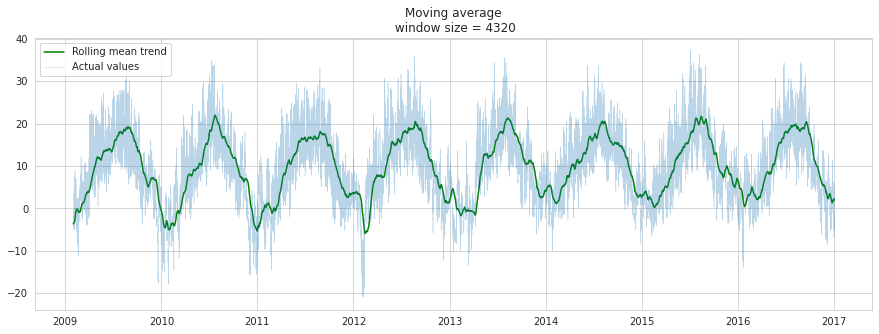

In [ ]:
# Усредненное значение по окну приблизительно в месяц (6 измерений в час, 144 в день)
plotMovingAverage(df, 144 * 30) 

In [ ]:
uni_data = df.values

In [ ]:
# Нормализуем весь датасет по среднему/стд тестовой выборки
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

uni_data = (uni_data-uni_train_mean)/uni_train_std

In [ ]:
# Тренируем модель на 20 значениях прошлого и предсказываем следующее
univariate_past_history = 20
univariate_future_target = 0

# Делим датасет
x_train_uni, y_train_uni = univariate_data(dataset=uni_data,
                                           start_index=0,
                                           end_index=TRAIN_SPLIT,
                                           history_size=univariate_past_history,
                                           target_size=univariate_future_target)

x_val_uni, y_val_uni = univariate_data(dataset=uni_data,
                                       start_index=TRAIN_SPLIT,
                                       end_index=None,
                                       history_size=univariate_past_history,
                                       target_size=univariate_future_target)

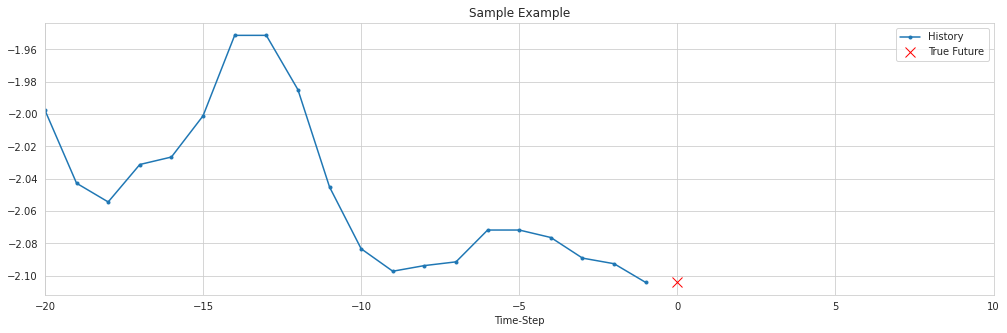

In [ ]:
# Так выглядит 20 шагов истории и следующее значение, которое нужно предсказать
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example');

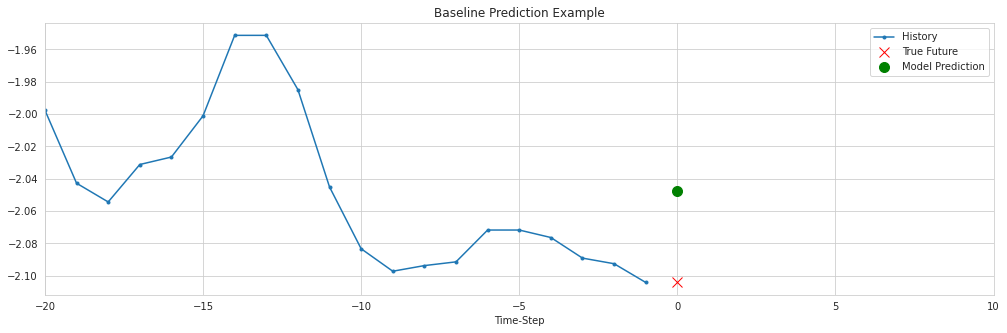

In [ ]:
# Простейший baseline - среднее значение исторических данных
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Baseline Prediction Example');

In [ ]:
# Обернем данные в tf.dataset
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [ ]:
# Простейшая модель на lstm
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
simple_lstm_model.fit(train_univariate,
                      epochs=4,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate,
                      callbacks=[early_stopping],
                      validation_steps=50)

Epoch 1/4
200/200 [==============================] - 2s 5ms/step - loss: 0.5999 - mae: 0.5999 - val_loss: 0.1337 - val_mae: 0.1337
Epoch 2/4
200/200 [==============================] - 1s 4ms/step - loss: 0.1245 - mae: 0.1245 - val_loss: 0.0333 - val_mae: 0.0333
Epoch 3/4
200/200 [==============================] - 1s 4ms/step - loss: 0.0455 - mae: 0.0455 - val_loss: 0.0250 - val_mae: 0.0250
Epoch 4/4
200/200 [==============================] - 1s 4ms/step - loss: 0.0391 - mae: 0.0391 - val_loss: 0.0223 - val_mae: 0.0223


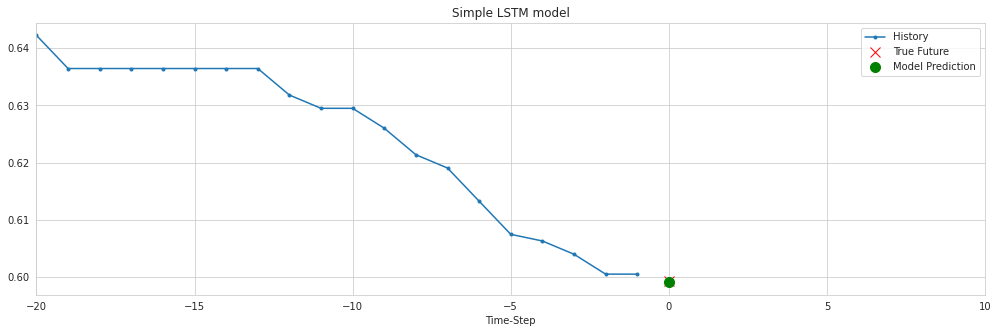

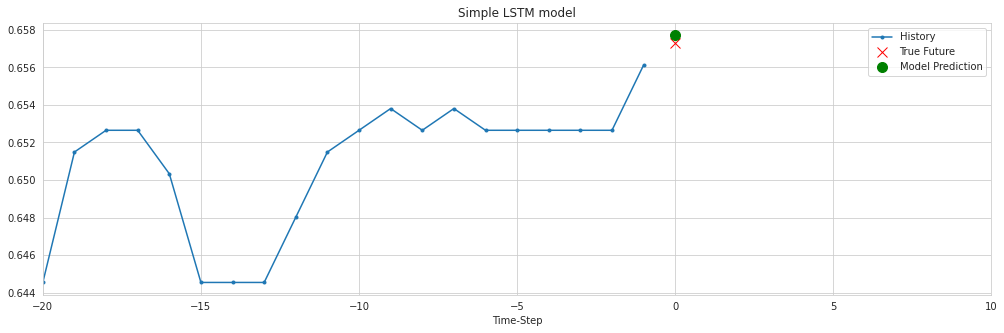

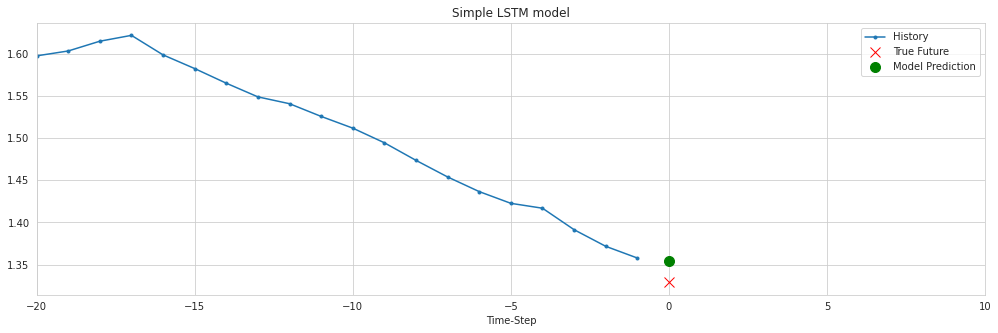

In [ ]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

Несмотря на то, что модель карйне проста и обучалась всего 4 эпохи результаты достаточно неплохие  

Попробуем несколько усложнить модель

In [ ]:
medium_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=x_train_uni.shape[-2:], return_sequences="True"),
    tf.keras.layers.LSTM(64, return_sequences="True"),
    tf.keras.layers.Conv1D(64, 3, activation="linear"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation="linear"),
    tf.keras.layers.Dense(1, activation="linear")
])

medium_lstm_model.compile(optimizer='adam', loss='mae', metrics=['mae'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
medium_lstm_model.fit(train_univariate,
                      epochs=50,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate,
                      callbacks=[early_stopping],
                      validation_steps=50)

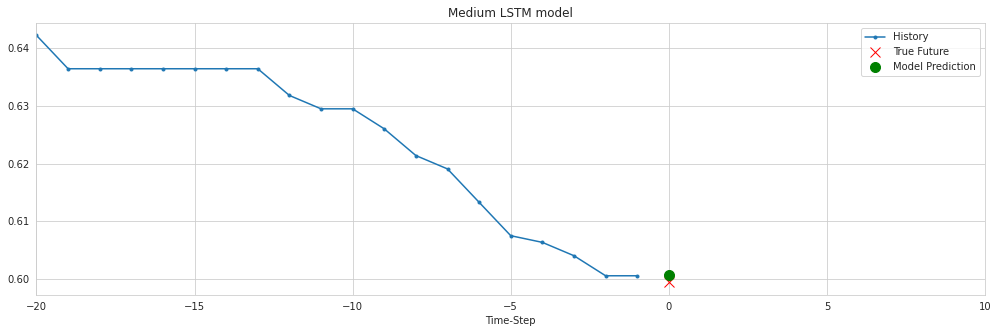

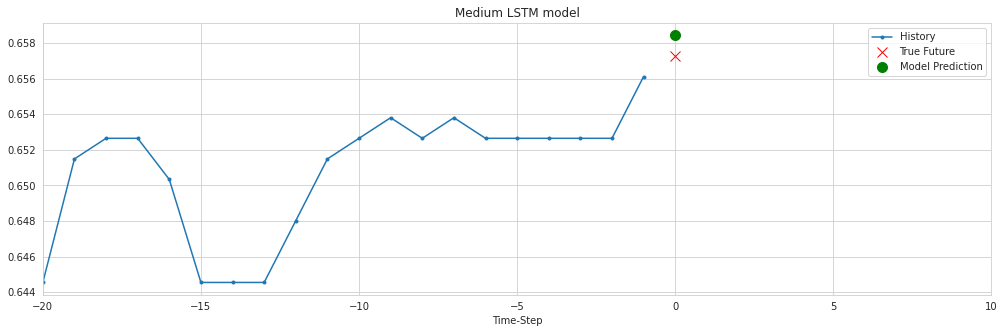

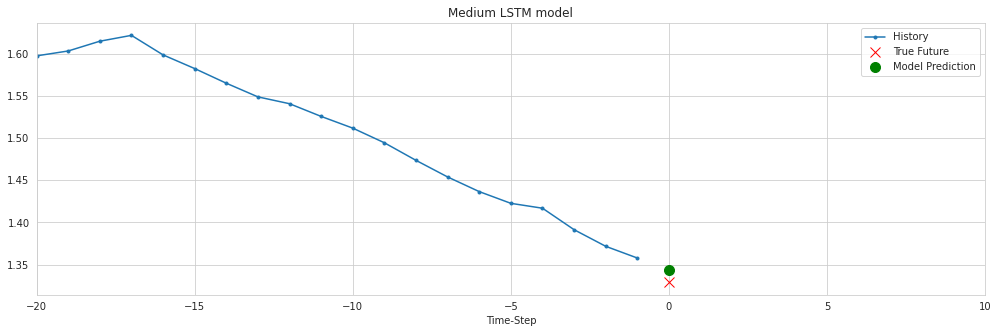

In [ ]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    medium_lstm_model.predict(x)[0]], 0, 'Medium LSTM model')
    plot.show()

Попробуем предсказать несколько батчей

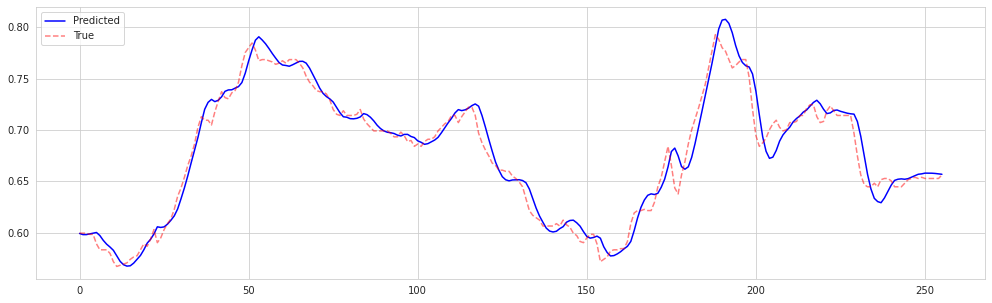

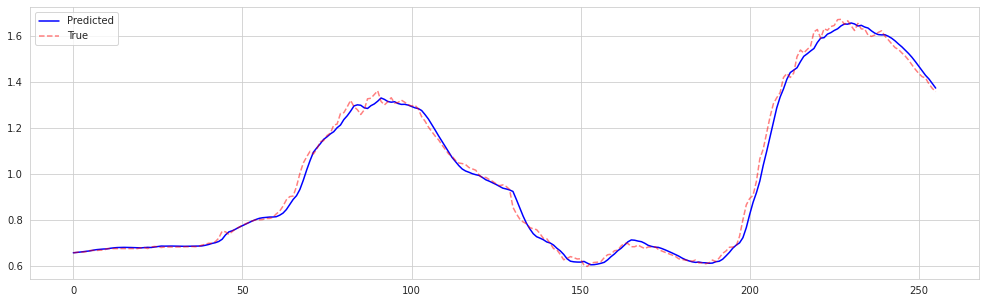

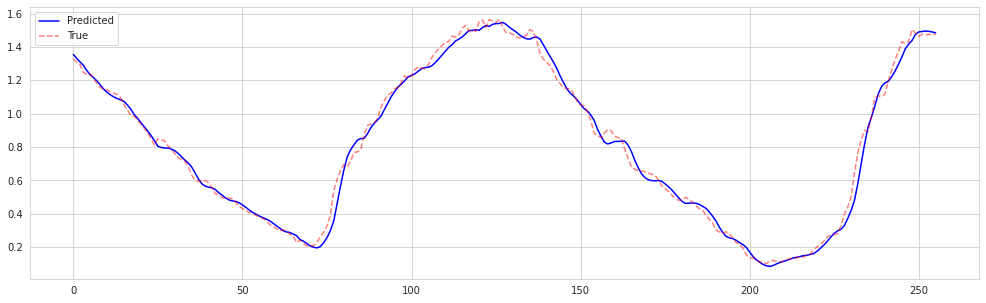

In [ ]:
for x, y in val_univariate.take(3):
    pred = simple_lstm_model.predict(x)
    plt.plot(pred, color='blue', label='Predicted')
    plt.plot(y, color='red',  alpha=.5, ls='dashed', label='True')
    plt.legend(loc='upper left')
    plt.show()

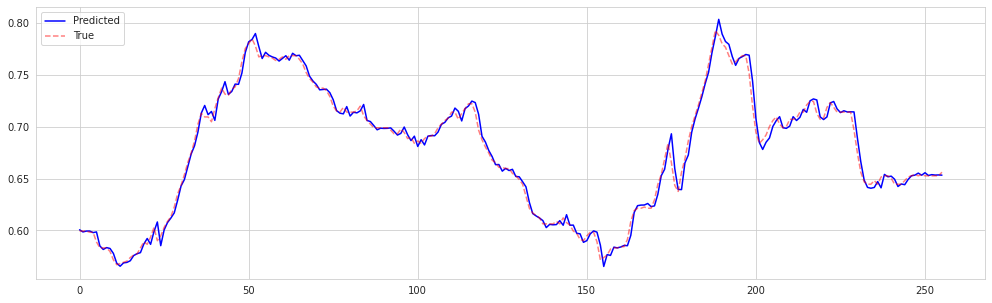

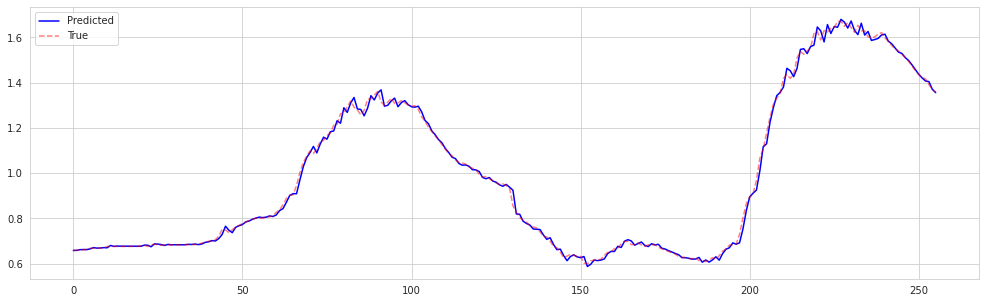

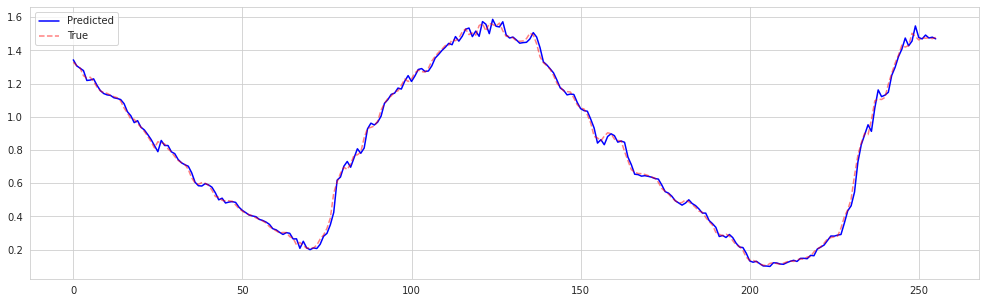

In [ ]:
for x, y in val_univariate.take(3):
    pred = medium_lstm_model.predict(x)
    plt.plot(pred, color='blue', label='Predicted')
    plt.plot(y, color='red',  alpha=.5, ls='dashed', label='True')
    plt.legend(loc='upper left')
    plt.show()

Видим, что более сложная и лучше обученная модель справляется лучше простейшей. Но, видимо в связи с тем, что сам временной ряд достаточно прост для обобщения, первая модель также показала неплохие результаты

___

### **Имплементация LSTM-ячейки**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# определим функции активации
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

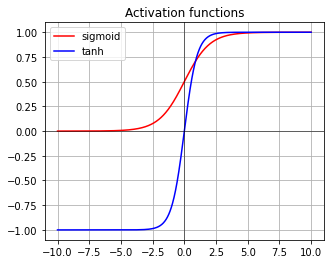

In [ ]:
# Нарисуем функции активации
x = np.linspace(-10, 10, 1000)

plt.figure(figsize=(5, 4))
plt.plot(x, sigmoid(x), color='red', label='sigmoid')
plt.plot(x, tanh(x), color='blue', label='tanh')
plt.grid()
plt.legend(loc='best')
plt.axvline(color='black', lw=.5)
plt.axhline(color='black', lw=.5)
plt.title('Activation functions')
plt.show()

![](https://hackernoon.com/hn-images/1*z4qT1SIp79JZ21x86w_4gA.jpeg)

![](https://habrastorage.org/r/w1560/web/bd0/43e/027/bd043e027a5c4454a735d43c651d7975.png)

Распишем, из чего состоит ячейка LSTM, пользуясь вышепредставленной диаграммой:

- В местах схождения линий происходит конкатенация векторов. Например вектор предыдущего состояния $h_{t-1}$ совмещается с вектором входной информации $X_t$
- В местах расхождения линии на две происходит копирование вектора
- Прямоугольники со знаками $\sigma, tanh $ - это полносвязанные слои с сигмоидной и тангенциальной функциями активации соответственно
- Кружки со знаком x - поэлементное умножение, со знаком + - поэлементное сложение, овал $tanh$ - "нормирование" вектора в диапазоне -1..1
![](https://habrastorage.org/r/w1560/web/db4/e23/6e1/db4e236e1d834c96949f17e94e8900c7.png)
- Верхняя линия фактически отвечает за запоминание/забывание важной информации. В поэлементном умножении проиходит ослабление значения входящего вектора $C_{t-1}$, так как выход с сигмоидальной функции находится в пределах от 0 до 1, соответственно в процессе обучения нужным данным выставляются веса близкие к 1, ненужным - к 0 

![](https://habrastorage.org/r/w1560/web/a5f/31a/104/a5f31a104b184217aca105de9ab6d320.png)

Видим, что функция $f_t$, может быть представлена следующим образом:  

$$ f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) $$  

где  
- $\sigma$ - сигмоидная функция активации
- $W_f$ - веса функции $f$
- $[h_{t-1}, x_t]$ - совмещенный вектор предыдущего состояния $h_{t-1}$ и входной информации $x_t$
- $b_f$ - смещение (bias) функции $f$

In [ ]:
#в виде кода

# для воспроизводимости
np.random.seed(42)

# сгенерируем фейковые входные данные
x = np.random.randn(5)

# предыдущее состояние ячейки (в случае первой итерации будут нули)
h_prev = np.zeros_like(x)

# веса, для первой итерации случайные величины нормального распределения
# количество строк равно количеству элементов которые мы хотим обновить
# пусть хотим обновить все значения, которых будет 5
wf = np.random.randn(5, 10)

# смещение также случайная величина
bf = np.random.randn(5)

# Соединяем вектора предыдущего состояния и входной информации
xc = np.hstack((x,  h_prev))
# dense слой с сигмоидой
f = sigmoid(np.dot(wf, xc) + bf)
f

array([0.56257646, 0.138573  , 0.33222729, 0.02552492, 0.9090861 ])

![](https://habrastorage.org/r/w1560/web/248/bf4/a75/248bf4a75ab74bf180b9c0e2e2cc5a58.png)

Аналогично, функция $i_t$:  

$$ i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) $$

где  
- $\sigma$ - сигмоидная функция активации
- $W_i$ - веса функции $i$
- $[h_{t-1}, x_t]$ - совмещенный вектор предыдущего состояния $h_{t-1}$ и входной информации $x_t$
- $b_i$ - смещение (bias) функции $i$

Функция $\tilde{C}$:  
$$\tilde{C} = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$

где  
- $\tanh$ - тангенциальная функция активации
- $W_C$ - веса функции $C$
- $[h_{t-1}, x_t]$ - совмещенный вектор предыдущего состояния $h_{t-1}$ и входной информации $x_t$
- $b_C$ - смещение (bias) функции $C$

Фактически на этом этапе происходит выбор с какие данные в векторе состояния следует обновить (сигмоидальная функция), после чего тангенциальная функция строит значения для обновления

In [ ]:
# Аналогично предыдущему случаю, отличие только в весах и смещении
wi = np.random.randn(5, 10)
bi = np.random.randn(5)

i = sigmoid(np.dot(wi, xc) + bi)
i

array([0.00769249, 0.9485126 , 0.56437218, 0.81988896, 0.09592599])

In [ ]:
# Для тангециальной функции
wc = np.random.randn(5, 10)
bc = np.random.randn(5)

c = tanh(np.dot(wc, xc) + bc)
c

array([ 0.87980623,  0.9603135 ,  0.99944376,  0.18207549, -0.99532124])

![](https://habrastorage.org/r/w1560/web/30e/ffa/7f9/30effa7f98274deaa65cf2e293f18365.png)

Этап забывания ненужной информации и добавления новой. 

In [ ]:
# Допустим, предыдущее значение c_pred было
c_pred = np.random.randn(5)

# наше новое состояние ячейки будет
Ct = f * c_pred + i * c
Ct

array([0.47212173, 0.91267116, 1.04696194, 0.14252634, 2.3773908 ])

![](https://habrastorage.org/r/w1560/web/16d/5b5/783/16d5b5783ba34244afcf0f240133fb28.png)

На выход с ячейки приходит выход с текущего состояния ячейки нормированный тангенсом, и сигмоидальным слоем входной информации

In [ ]:
wo = np.random.randn(5, 10)
bo = np.random.randn(5)

# вычисли наше новое выходное значение h_t
ot = sigmoid(np.dot(wo, xc) + bo)
ht = ot * tanh(Ct)
ht

array([0.03514069, 0.62992944, 0.43092009, 0.01422867, 0.34539612])